<a href="https://colab.research.google.com/github/tedjr/misinformation-containment/blob/main/Misinformation_Containment_Simulations_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cupy-cuda12x

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cugraph-cu12 cupy-cuda12x

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 224.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 128.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 35.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of cugraph-cu12 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 155.1 MB/s eta 0:00:00


In [ ]:
import cudf
import cugraph
import cupy

print("✅ RAPIDS is fully working!")


✅ RAPIDS is fully working!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 📂 Load the Facebook graph
file_path = "/content/drive/MyDrive/facebook_combined.txt"
df = cudf.read_csv(file_path, delim_whitespace=True, names=["src", "dst"], dtype=["int32", "int32"])
G = cugraph.Graph()
G.from_cudf_edgelist(df, source='src', destination='dst', renumber=True)
num_nodes = G.number_of_vertices()
print(f"✅ Loaded GPU graph with {G.number_of_vertices()} nodes and {G.number_of_edges()} edges")


/usr/local/lib/python3.12/dist-packages/cudf/io/csv.py:88: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  warnings.warn(


✅ Loaded GPU graph with 4039 nodes and 88234 edges


In [ ]:
# Build CSR adjacency as cupyx sparse (undirected)
adj_view = G.view_adj_list()  # returns (offsets, indices, weights) on some versions
if isinstance(adj_view, tuple):
    offsets, indices = adj_view[0], adj_view[1]
else:
    offsets, indices = adj_view.offsets, adj_view.indices

import cupy as cp
from cupyx.scipy.sparse import csr_matrix
indptr  = cp.asarray(offsets.values)
indices = cp.asarray(indices.values)
data    = cp.ones_like(indices, dtype=cp.float32)
adj_matrix = csr_matrix((data, indices, indptr), shape=(num_nodes, num_nodes))


In [ ]:
# === PRECOMPUTE centralities ONCE (safe to run once per session) ===
seed_sizes = [5, 10, 15, 20]

# Node betweenness
bc_nodes = cugraph.betweenness_centrality(G, k=None, normalized=True)
bc_nodes = bc_nodes.sort_values("betweenness_centrality", ascending=False).reset_index(drop=True)

# Edge betweenness
bc_edges = cugraph.edge_betweenness_centrality(G)
bc_edges = bc_edges.sort_values("betweenness_centrality", ascending=False).reset_index(drop=True)

# Degree (for degree-based node blocking) — fallback via CSR offsets
adj_view = G.view_adj_list()  # returns (offsets, indices, weights) on some versions
if isinstance(adj_view, tuple):
    offsets = adj_view[0]
else:
    offsets = adj_view.offsets

import cupy as cp
# degree[i] = offsets[i+1] - offsets[i]
_off = cp.asarray(offsets.values)
_deg = (_off[1:] - _off[:-1]).astype(cp.int32)
_vertices = cp.arange(num_nodes, dtype=cp.int32)

import cudf
deg_df = cudf.DataFrame({
    "vertex": cudf.Series(_vertices),
    "degree": cudf.Series(_deg)
}).sort_values("degree", ascending=False).reset_index(drop=True)

# Build top-k caches
top_nodes_dict, top_edges_dict, top_degree_nodes = {}, {}, {}
for k in seed_sizes:
    top_nodes_dict[k]   = bc_nodes["vertex"].head(k).to_pandas().tolist()
    e_k                 = bc_edges.head(k)[["src", "dst"]].to_pandas()
    top_edges_dict[k]   = list(map(tuple, e_k.values))
    top_degree_nodes[k] = deg_df["vertex"].head(k).to_pandas().tolist()

print("✅ Centralities cached")


✅ Centralities cached


In [ ]:
# === Shared seed registry for strict fairness across models ===
seed_registry = {}  # (k, run) -> cupy int32 array

def get_shared_seeds(k, run, n=num_nodes):
    key = (k, run)
    if key not in seed_registry:
        cupy.random.seed(run)  # reproducible
        seed_registry[key] = cupy.random.choice(
            cupy.arange(n, dtype=cupy.int32), k, replace=False
        )
    return seed_registry[key]



=== SEED SETS USED PER RUN AND STRATEGY (IC, k=5) ===

Model: IC, Seed size k=5, Run=0 -> Baseline Seeds: [1058, 781, 576, 582, 2130]
    ↳ Node Blocking (Betweenness) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Node Blocking (Degree) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Edge Blocking (Betweenness) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Edge Blocking (Random) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Truth Campaign Seeds: [1058, 781, 576, 582, 2130]


/usr/local/lib/python3.12/dist-packages/cupyx/scipy/sparse/_compressed.py:548: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive.
  warnings.warn('Changing the sparsity structure of a '


🚩 WARNING: IC | k=5 | run=0 -> Edge Blocking (Betweenness) infected 9 > Baseline 8

Model: IC, Seed size k=5, Run=1 -> Baseline Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Node Blocking (Betweenness) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Node Blocking (Degree) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Edge Blocking (Betweenness) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Edge Blocking (Random) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Truth Campaign Seeds: [3164, 2342, 37, 2205, 146]

Model: IC, Seed size k=5, Run=2 -> Baseline Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Node Blocking (Betweenness) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Node Blocking (Degree) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Edge Blocking (Betweenness) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Edge Blocking (Random) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Truth Campaign Seeds: [493, 2184, 1259, 1502, 927]
🚩 WARNING: IC | k=5 | run=2 -> Edge Blocking (Random) infected 102 > Baseline 99

Model: IC, Seed size k=5,

/tmp/ipython-input-889797366.py:176: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x="k", y="Mean Infected", hue="Strategy", ci=None)


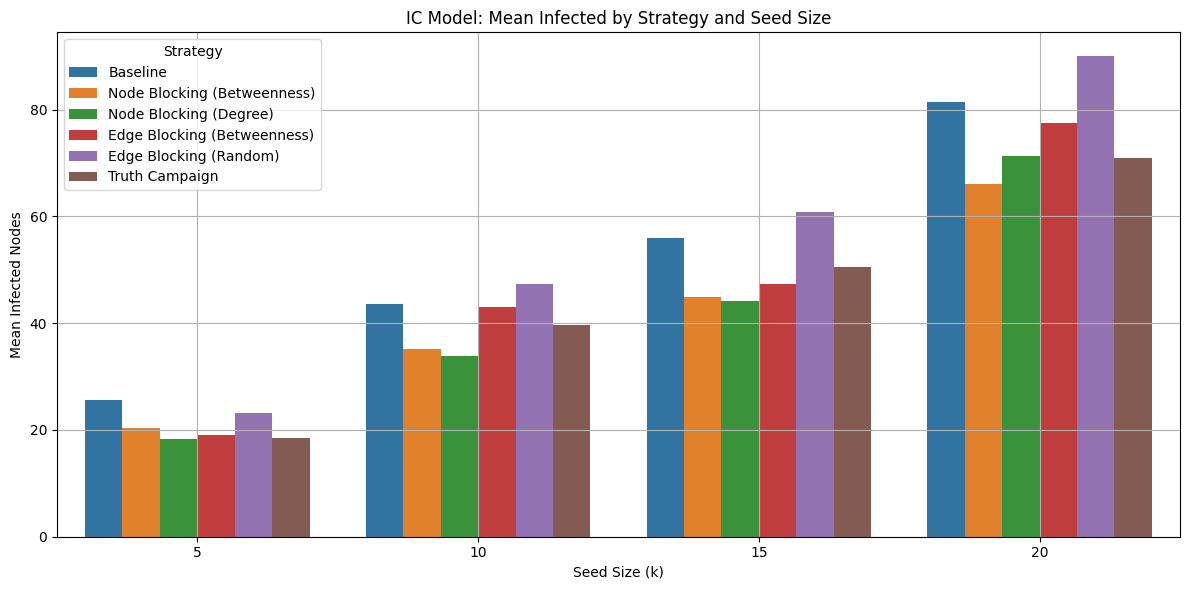

In [ ]:
# ===========================================
# ✅ Full GPU IC Simulation with Seed Consistency & Logging
# (assumes: num_nodes, adj_matrix, top_nodes_dict, top_degree_nodes, top_edges_dict already exist)
# ===========================================

import cupy
import cudf
import cugraph
from cupyx.scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from collections import defaultdict


# === IC Diffusion Model ===
def independent_cascade_gpu(G_adj, seed_nodes, p=0.05, max_steps=10):
    N = G_adj.shape[0]
    infected = cupy.zeros(N, dtype=cupy.bool_)
    frontier = cupy.zeros(N, dtype=cupy.bool_)
    infected[seed_nodes] = True
    frontier[seed_nodes] = True

    for _ in range(max_steps):
        neighbors = G_adj.T.dot(frontier.astype(cupy.int32)) > 0
        new_infections = neighbors & (~infected) & (cupy.random.random(N) < p)
        if not new_infections.any():
            break
        infected |= new_infections
        frontier = new_infections

    return int(cupy.count_nonzero(infected).item())

# === Truth Campaign (competitive IC, truth vs misinfo) ===
def truth_campaign_ic_gpu(G_adj, misinfo_seeds, truth_seeds, p=0.05, max_steps=10):
    N = G_adj.shape[0]
    state = cupy.zeros(N, dtype=cupy.int8)  # 0 = uninfluenced, 1 = misinfo, 2 = truth
    state[misinfo_seeds] = 1
    state[truth_seeds] = 2

    frontier_m = cupy.zeros(N, dtype=cupy.bool_)
    frontier_t = cupy.zeros(N, dtype=cupy.bool_)
    frontier_m[misinfo_seeds] = True
    frontier_t[truth_seeds] = True

    for _ in range(max_steps):
        m_infect = G_adj.T.dot(frontier_m.astype(cupy.int32)) > 0
        t_infect = G_adj.T.dot(frontier_t.astype(cupy.int32)) > 0

        new_m = (state == 0) & m_infect & (cupy.random.random(N) < p)
        new_t = (state == 0) & t_infect & (cupy.random.random(N) < p)

        if not new_m.any() and not new_t.any():
            break

        # If both try to activate the same node in this step, give truth priority
        both = new_m & new_t
        new_t = new_t | both
        new_m = new_m & (~both)

        state[new_m] = 1
        state[new_t] = 2

        frontier_m = new_m
        frontier_t = new_t

    return int(cupy.count_nonzero(state == 1).item())

# === Run all strategies for a given k, with logging & fairness ===
def run_strategy_with_logging(k, runs=10, p=0.05, max_steps=10):
    results = defaultdict(list)
    all_nodes = cupy.arange(num_nodes, dtype=cupy.int32)

    # Precomputed caches
    blocked_nodes_btwn = cupy.array(top_nodes_dict[k],   dtype=cupy.int32)
    blocked_nodes_deg  = cupy.array(top_degree_nodes[k], dtype=cupy.int32)  # degree-based
    edge_blocked_btwn  = top_edges_dict[k]
    edge_blocked_rand  = top_edges_dict[k][::-1]  # simple randomized counterpart

    print(f"\n=== SEED SETS USED PER RUN AND STRATEGY (IC, k={k}) ===")

    for run in range(runs):
        # ✅ Shared, reproducible seed set (so LT can reuse the same later)
        base_seed_set = get_shared_seeds(k, run)
        base_seed_list = base_seed_set.tolist()
        print(f"\nModel: IC, Seed size k={k}, Run={run} -> Baseline Seeds: {base_seed_list}")
        print(f"    ↳ Node Blocking (Betweenness) Seeds: {base_seed_list}")
        print(f"    ↳ Node Blocking (Degree) Seeds: {base_seed_list}")
        print(f"    ↳ Edge Blocking (Betweenness) Seeds: {base_seed_list}")
        print(f"    ↳ Edge Blocking (Random) Seeds: {base_seed_list}")
        print(f"    ↳ Truth Campaign Seeds: {base_seed_list}")

        # Build edge-blocked adjacency variants (undirected: zero both directions)
        adj_edge_block_btwn = adj_matrix.copy()
        rows, cols = zip(*edge_blocked_btwn) if len(edge_blocked_btwn) else ([], [])
        if rows:
            adj_edge_block_btwn[list(rows), list(cols)] = 0
            adj_edge_block_btwn[list(cols), list(rows)] = 0

        adj_edge_block_rand = adj_matrix.copy()
        rrows, rcols = zip(*edge_blocked_rand) if len(edge_blocked_rand) else ([], [])
        if rrows:
            adj_edge_block_rand[list(rrows), list(rcols)] = 0
            adj_edge_block_rand[list(rcols), list(rrows)] = 0

        # Helper: seeds after node removal (warn if any dropped)
        def valid_after_removal(seed_set, removed_nodes):
            valids = cupy.setdiff1d(seed_set, removed_nodes)
            if valids.size < seed_set.size:
                dropped = sorted(set(seed_set.get()) - set(valids.get()))
                print(f"⚠️ Seeds dropped due to node removal: {dropped}")
            return valids

        # --- Run baseline
        baseline = independent_cascade_gpu(adj_matrix, base_seed_set, p=p, max_steps=max_steps)

        # --- Node Blocking
        valid_nb_btwn = valid_after_removal(base_seed_set, blocked_nodes_btwn)
        infected_nb_btwn = independent_cascade_gpu(adj_matrix, valid_nb_btwn, p=p, max_steps=max_steps)

        valid_nb_deg  = valid_after_removal(base_seed_set, blocked_nodes_deg)
        infected_nb_deg = independent_cascade_gpu(adj_matrix, valid_nb_deg, p=p, max_steps=max_steps)

        # --- Edge Blocking
        infected_eb_btwn = independent_cascade_gpu(adj_edge_block_btwn, base_seed_set, p=p, max_steps=max_steps)
        infected_eb_rand = independent_cascade_gpu(adj_edge_block_rand, base_seed_set, p=p, max_steps=max_steps)

        # --- Truth Campaign (competitive IC)
        truth_pool   = cupy.setdiff1d(all_nodes, base_seed_set)
        truth_seeds  = cupy.random.choice(truth_pool, k, replace=False)
        infected_truth = truth_campaign_ic_gpu(adj_matrix, base_seed_set, truth_seeds, p=p, max_steps=max_steps)

        # Store
        results['Baseline'].append(baseline)
        results['Node Blocking (Betweenness)'].append(infected_nb_btwn)
        results['Node Blocking (Degree)'].append(infected_nb_deg)
        results['Edge Blocking (Betweenness)'].append(infected_eb_btwn)
        results['Edge Blocking (Random)'].append(infected_eb_rand)
        results['Truth Campaign'].append(infected_truth)

        # 🚩 Never-worse-than-baseline check (per run)
        for name, val in [
            ("Node Blocking (Betweenness)", infected_nb_btwn),
            ("Node Blocking (Degree)",      infected_nb_deg),
            ("Edge Blocking (Betweenness)", infected_eb_btwn),
            ("Edge Blocking (Random)",      infected_eb_rand),
            ("Truth Campaign",              infected_truth),
        ]:
            if val > baseline:
                print(f"🚩 WARNING: IC | k={k} | run={run} -> {name} infected {val} > Baseline {baseline}")

    # Mean per strategy
    return {k: float(cupy.mean(cupy.asarray(v))) for k, v in results.items()}

# === RUN ALL (IC) ===
seed_sizes = [5, 10, 15, 20]
final_results = {}
start = time.time()
for k in seed_sizes:
    final_results[k] = run_strategy_with_logging(k, runs=10, p=0.05, max_steps=10)
end = time.time()
print(f"\n⏱ Total GPU IC simulation time: {round(end - start, 2)} seconds")

# Keep a copy for later comparison with LT
final_results_ic = final_results

# === PLOT (IC) ===
rows = []
for k_val, strategy_results in final_results_ic.items():
    for strategy, mean_infected in strategy_results.items():
        rows.append({"k": k_val, "Strategy": strategy, "Mean Infected": mean_infected})

df_plot = pd.DataFrame(rows)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x="k", y="Mean Infected", hue="Strategy", ci=None)
plt.title("IC Model: Mean Infected by Strategy and Seed Size")
plt.xlabel("Seed Size (k)")
plt.ylabel("Mean Infected Nodes")
plt.legend(title="Strategy")
plt.grid(True)
plt.tight_layout()
plt.show()



=== SEED SETS USED PER RUN AND STRATEGY (LT, k=5) ===

Model: LT, Seed size k=5, Run=0 -> Baseline Seeds: [1058, 781, 576, 582, 2130]
    ↳ Node Blocking (Betweenness) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Node Blocking (Degree) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Edge Blocking (Betweenness) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Edge Blocking (Random) Seeds: [1058, 781, 576, 582, 2130]
    ↳ Truth Campaign Seeds: [1058, 781, 576, 582, 2130]


/usr/local/lib/python3.12/dist-packages/cupyx/scipy/sparse/_compressed.py:548: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive.
  warnings.warn('Changing the sparsity structure of a '



Model: LT, Seed size k=5, Run=1 -> Baseline Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Node Blocking (Betweenness) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Node Blocking (Degree) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Edge Blocking (Betweenness) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Edge Blocking (Random) Seeds: [3164, 2342, 37, 2205, 146]
    ↳ Truth Campaign Seeds: [3164, 2342, 37, 2205, 146]

Model: LT, Seed size k=5, Run=2 -> Baseline Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Node Blocking (Betweenness) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Node Blocking (Degree) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Edge Blocking (Betweenness) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Edge Blocking (Random) Seeds: [493, 2184, 1259, 1502, 927]
    ↳ Truth Campaign Seeds: [493, 2184, 1259, 1502, 927]

Model: LT, Seed size k=5, Run=3 -> Baseline Seeds: [2815, 23, 227, 2890, 1231]
    ↳ Node Blocking (Betweenness) Seeds: [2815, 23, 227, 2890, 1231]
    ↳ Node Blocking (Degree) Seeds: [2815

/tmp/ipython-input-4217908963.py:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=lt_plot_df, x="k", y="Mean Infected", hue="Strategy", ci=None)


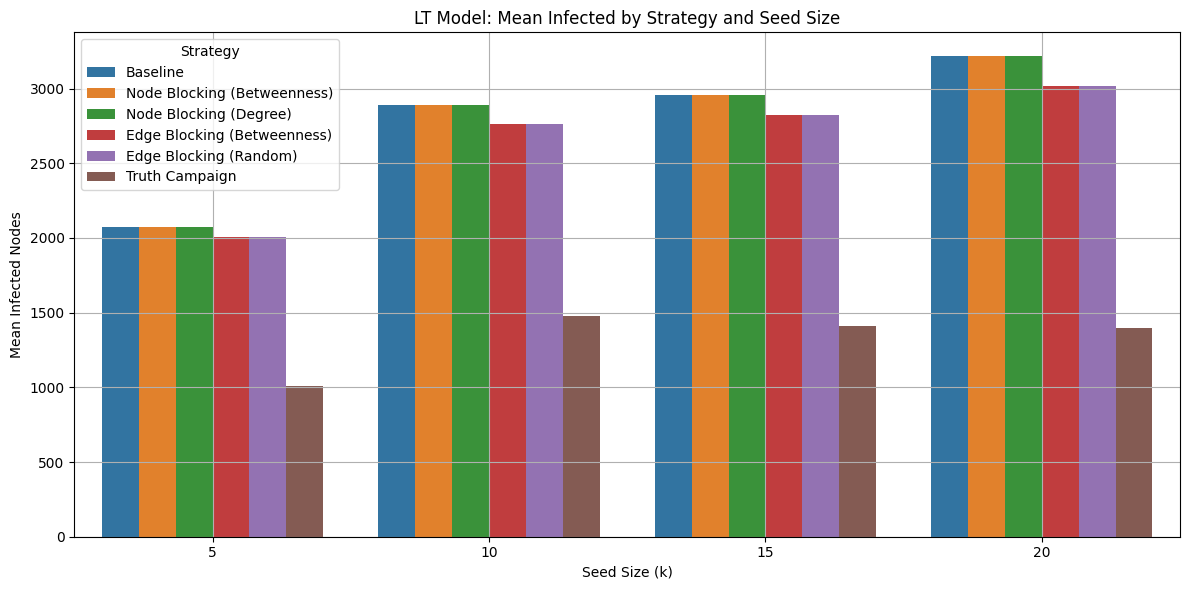

In [ ]:
# ===========================================
# ✅ Full GPU LT Simulation with Seed Consistency & Logging
# (uses shared seeds + degree-based blocking + warnings)
# ===========================================

import cupy
import cudf
import cugraph
from cupyx.scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from collections import defaultdict

# === LT Diffusion Model (unchanged) ===
def linear_threshold_gpu(G_adj, seed_nodes, thresholds=None, max_steps=10):
    N = G_adj.shape[0]
    active = cupy.zeros(N, dtype=cupy.bool_)
    active[seed_nodes] = True
    if thresholds is None:
        thresholds = cupy.random.uniform(0.1, 0.5, N)

    for _ in range(max_steps):
        influence = G_adj.T.dot(active.astype(cupy.float32))
        new_active = (influence >= thresholds) & (~active)
        if not new_active.any():
            break
        active |= new_active

    return int(cupy.count_nonzero(active).item())

# === Truth Campaign for LT (unchanged) ===
def truth_campaign_lt_gpu(G_adj, misinfo_seeds, truth_seeds, thresholds=None, max_steps=10):
    N = G_adj.shape[0]
    state = cupy.zeros(N, dtype=cupy.int8)  # 0 = inactive, 1 = misinfo, 2 = truth
    state[misinfo_seeds] = 1
    state[truth_seeds] = 2
    if thresholds is None:
        thresholds = cupy.random.uniform(0.1, 0.5, N)

    for _ in range(max_steps):
        infl_m = G_adj.T.dot((state == 1).astype(cupy.float32))
        infl_t = G_adj.T.dot((state == 2).astype(cupy.float32))
        new_m = (state == 0) & (infl_m >= thresholds)
        new_t = (state == 0) & (infl_t >= thresholds)
        if not new_m.any() and not new_t.any():
            break
        state[new_m] = 1
        state[new_t] = 2

    return int(cupy.count_nonzero(state == 1).item())

# === Run all strategies for LT (shared seeds + degree blocking + warnings) ===
def run_strategy_lt_with_logging(k, runs=10, max_steps=10):
    results = defaultdict(list)
    all_nodes = cupy.arange(num_nodes, dtype=cupy.int32)

    # Precomputed caches
    blocked_nodes_btwn = cupy.array(top_nodes_dict[k],   dtype=cupy.int32)
    blocked_nodes_deg  = cupy.array(top_degree_nodes[k], dtype=cupy.int32)  # ✅ degree-based
    edge_blocked_btwn  = top_edges_dict[k]
    edge_blocked_rand  = top_edges_dict[k][::-1]

    print(f"\n=== SEED SETS USED PER RUN AND STRATEGY (LT, k={k}) ===")

    for run in range(runs):
        # ✅ Shared seeds (same as IC for fairness)
        base_seed_set = get_shared_seeds(k, run)
        base_seed_list = base_seed_set.tolist()
        thresholds = cupy.random.uniform(0.1, 0.5, num_nodes)

        print(f"\nModel: LT, Seed size k={k}, Run={run} -> Baseline Seeds: {base_seed_list}")
        print(f"    ↳ Node Blocking (Betweenness) Seeds: {base_seed_list}")
        print(f"    ↳ Node Blocking (Degree) Seeds: {base_seed_list}")
        print(f"    ↳ Edge Blocking (Betweenness) Seeds: {base_seed_list}")
        print(f"    ↳ Edge Blocking (Random) Seeds: {base_seed_list}")
        print(f"    ↳ Truth Campaign Seeds: {base_seed_list}")

        # Build edge-blocked adjacency variants (undirected: zero both directions)
        adj_edge_block_btwn = adj_matrix.copy()
        rows, cols = zip(*edge_blocked_btwn) if len(edge_blocked_btwn) else ([], [])
        if rows:
            adj_edge_block_btwn[list(rows), list(cols)] = 0
            adj_edge_block_btwn[list(cols), list(rows)] = 0

        adj_edge_block_rand = adj_matrix.copy()
        rrows, rcols = zip(*edge_blocked_rand) if len(edge_blocked_rand) else ([], [])
        if rrows:
            adj_edge_block_rand[list(rrows), list(rcols)] = 0
            adj_edge_block_rand[list(rcols), list(rrows)] = 0

        # Helper: seeds after node removal (warn if any dropped)
        def valid_after_removal(seed_set, removed_nodes):
            valids = cupy.setdiff1d(seed_set, removed_nodes)
            if valids.size < seed_set.size:
                dropped = sorted(set(seed_set.get()) - set(valids.get()))
                print(f"⚠️ Seeds dropped due to node removal: {dropped}")
            return valids

        # --- Baseline
        baseline = linear_threshold_gpu(adj_matrix, base_seed_set, thresholds=thresholds, max_steps=max_steps)

        # --- Node Blocking
        valid_nb_btwn    = valid_after_removal(base_seed_set, blocked_nodes_btwn)
        infected_nb_btwn = linear_threshold_gpu(adj_matrix, valid_nb_btwn, thresholds=thresholds, max_steps=max_steps)

        valid_nb_deg     = valid_after_removal(base_seed_set, blocked_nodes_deg)
        infected_nb_deg  = linear_threshold_gpu(adj_matrix, valid_nb_deg, thresholds=thresholds, max_steps=max_steps)

        # --- Edge Blocking
        infected_eb_btwn = linear_threshold_gpu(adj_edge_block_btwn, base_seed_set, thresholds=thresholds, max_steps=max_steps)
        infected_eb_rand = linear_threshold_gpu(adj_edge_block_rand, base_seed_set, thresholds=thresholds, max_steps=max_steps)

        # --- Truth Campaign (competitive LT)
        truth_pool   = cupy.setdiff1d(all_nodes, base_seed_set)
        truth_seeds  = cupy.random.choice(truth_pool, k, replace=False)
        infected_truth = truth_campaign_lt_gpu(adj_matrix, base_seed_set, truth_seeds, thresholds=thresholds, max_steps=max_steps)

        # Store
        results['Baseline'].append(baseline)
        results['Node Blocking (Betweenness)'].append(infected_nb_btwn)
        results['Node Blocking (Degree)'].append(infected_nb_deg)
        results['Edge Blocking (Betweenness)'].append(infected_eb_btwn)
        results['Edge Blocking (Random)'].append(infected_eb_rand)
        results['Truth Campaign'].append(infected_truth)

        # 🚩 Never-worse-than-baseline check
        for name, val in [
            ("Node Blocking (Betweenness)", infected_nb_btwn),
            ("Node Blocking (Degree)",      infected_nb_deg),
            ("Edge Blocking (Betweenness)", infected_eb_btwn),
            ("Edge Blocking (Random)",      infected_eb_rand),
            ("Truth Campaign",              infected_truth),
        ]:
            if val > baseline:
                print(f"🚩 WARNING: LT | k={k} | run={run} -> {name} infected {val} > Baseline {baseline}")

    # Mean per strategy
    return {k: float(cupy.mean(cupy.asarray(v))) for k, v in results.items()}

# === RUN (LT) ===
seed_sizes = [5, 10, 15, 20]
final_results_lt = {}
start = time.time()
for k in seed_sizes:
    final_results_lt[k] = run_strategy_lt_with_logging(k, runs=10, max_steps=10)
end = time.time()
print(f"\n⏱ Total GPU LT simulation time: {round(end - start, 2)} seconds")

# === PLOT (LT) ===
rows = []
for k_val, strategy_results in final_results_lt.items():
    for strategy, mean_infected in strategy_results.items():
        rows.append({"k": k_val, "Strategy": strategy, "Mean Infected": mean_infected})

lt_plot_df = pd.DataFrame(rows)
plt.figure(figsize=(12, 6))
sns.barplot(data=lt_plot_df, x="k", y="Mean Infected", hue="Strategy", ci=None)
plt.title("LT Model: Mean Infected by Strategy and Seed Size")
plt.xlabel("Seed Size (k)")
plt.ylabel("Mean Infected Nodes")
plt.legend(title="Strategy")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ Summary (head):
  Model  k                     Strategy  Mean Infected  \
0    IC  5                     Baseline           25.6   
1    IC  5  Node Blocking (Betweenness)           20.4   
2    IC  5       Node Blocking (Degree)           18.3   
3    IC  5  Edge Blocking (Betweenness)           19.0   
4    IC  5       Edge Blocking (Random)           23.2   

   % Reduction vs Baseline  
0                 0.000000  
1                20.312500  
2                28.515625  
3                25.781250  
4                 9.375000  


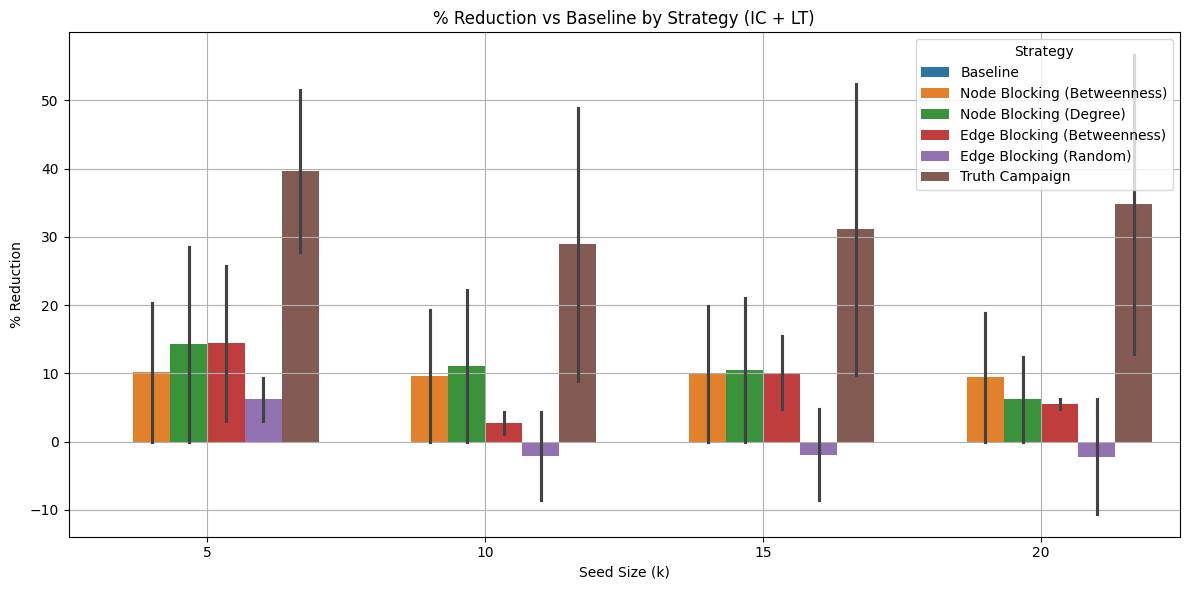

In [ ]:
def dict_to_rows(results_dict, model_label):
    rows = []
    for k, strat_dict in results_dict.items():
        base = strat_dict["Baseline"]
        for strat, val in strat_dict.items():
            rows.append({
                "Model": model_label,
                "k": k,
                "Strategy": strat,
                "Mean Infected": val,
                "% Reduction vs Baseline": 0.0 if strat=="Baseline" else (base - val) / base * 100.0
            })
    return rows

df_ic = pd.DataFrame(dict_to_rows(final_results_ic, "IC"))
df_lt = pd.DataFrame(dict_to_rows(final_results_lt, "LT"))
df_summary = pd.concat([df_ic, df_lt], ignore_index=True)
print("\n✅ Summary (head):")
print(df_summary.head())

plt.figure(figsize=(12,6))
sns.barplot(data=df_summary, x="k", y="% Reduction vs Baseline", hue="Strategy")
plt.title("% Reduction vs Baseline by Strategy (IC + LT)")
plt.xlabel("Seed Size (k)")
plt.ylabel("% Reduction")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2455119925.py:43: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


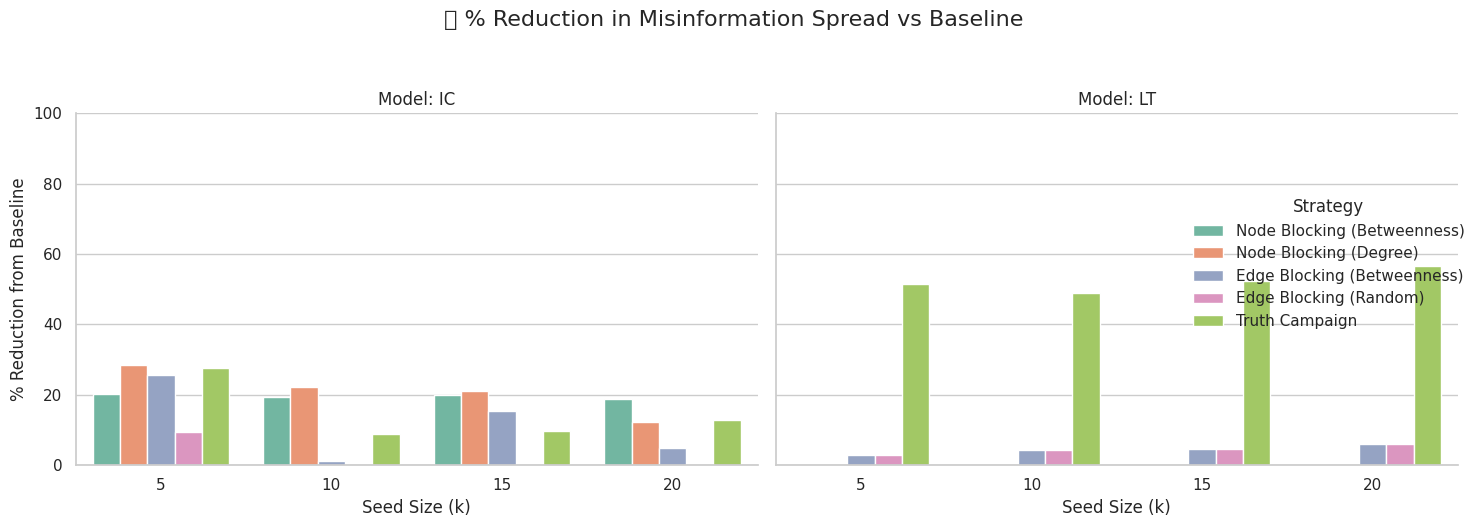

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_reduction_heatmap(results_dict, model_name):
    heatmap_data = []
    for k, strategy_scores in results_dict.items():
        baseline = strategy_scores["Baseline"]
        for strategy, score in strategy_scores.items():
            if strategy != "Baseline":
                reduction = ((baseline - score) / baseline) * 100
                heatmap_data.append({
                    "Seed Size (k)": k,
                    "Strategy": strategy,
                    "Reduction (%)": reduction,
                    "Model": model_name
                })
    return pd.DataFrame(heatmap_data)

# Build heatmap-ready DataFrame
df_ic = create_reduction_heatmap(final_results_ic, "IC")
df_lt = create_reduction_heatmap(final_results_lt, "LT")
df_heatmap = pd.concat([df_ic, df_lt])

# 📊 Plot side-by-side grouped bar plot
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_heatmap,
    x="Seed Size (k)",
    y="Reduction (%)",
    hue="Strategy",
    col="Model",
    kind="bar",
    height=5,
    aspect=1.2,
    palette="Set2"
)

g.set_titles("Model: {col_name}")
g.set_axis_labels("Seed Size (k)", "% Reduction from Baseline")
g.set(ylim=(0, 100))
g.fig.suptitle("📉 % Reduction in Misinformation Spread vs Baseline", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
# AUTO-RECOVER + EXPORT RESULTS for Figures notebook (robust)
# Expects an aggregated df_summary; builds df_final in required schema.
# =========================================================
import pandas as pd
import numpy as np
from pathlib import Path

REQUIRED_FINAL = ["model", "strategy", "k", "run", "final_infected", "n_nodes"]

def _first_present(df, candidates, default=None):
    """Return the first column in 'candidates' that exists in df, else default."""
    for c in candidates:
        if c in df.columns:
            return c
    return default

if 'df_summary' in globals() and isinstance(df_summary, pd.DataFrame) and len(df_summary):
    print("✅ Found df_summary. Preparing df_final for export...")

    df = df_summary.copy()

    # --- Robust column mapping ---
    col_map = {}
    # Model / Strategy / k
    model_col    = _first_present(df, ["Model", "model", "MODEL"])
    strat_col    = _first_present(df, ["Strategy", "strategy", "STRATEGY", "strategy_name"])
    k_col        = _first_present(df, ["k", "K", "budget", "seed_budget"])

    # Mean infected (aggregated)
    mean_inf_col = _first_present(df, ["Mean Infected", "mean_infected", "mean", "final_infected_mean", "avg_infected"])

    # Apply renaming if found
    if model_col: col_map[model_col] = "model"
    if strat_col: col_map[strat_col] = "strategy"
    if k_col:     col_map[k_col]     = "k"
    if mean_inf_col: col_map[mean_inf_col] = "final_infected"

    df.rename(columns=col_map, inplace=True)

    # --- Validate required core columns present ---
    missing = [c for c in ["model","strategy","k","final_infected"] if c not in df.columns]
    if missing:
        raise KeyError(f"❌ df_summary is missing required columns (after renaming): {missing}. "
                       f"Available columns: {list(df.columns)}")

    # --- n_nodes: prefer provided num_nodes; else fallback; else NaN ---
    if 'num_nodes' in globals() and isinstance(num_nodes, (int, np.integer)):
        n_nodes_val = int(num_nodes)
    else:
        # sensible fallback for the Facebook graph; change if needed
        n_nodes_val = 4039
        print(f"ℹ️ 'num_nodes' not found; using fallback n_nodes={n_nodes_val}")

    # --- Construct df_final schema ---
    df_final = pd.DataFrame({
        "model":          df["model"].astype(str),
        "strategy":       df["strategy"].astype(str),
        "k":              pd.to_numeric(df["k"], errors="coerce").astype("Int64"),
        "run":            0,  # aggregated summary => single pseudo-run
        "final_infected": pd.to_numeric(df["final_infected"], errors="coerce"),
        "n_nodes":        n_nodes_val
    })

    # --- Sanity checks ---
    # Missing values
    for col in ["model","strategy","k","final_infected"]:
        if df_final[col].isna().any():
            nmiss = int(df_final[col].isna().sum())
            print(f"⚠️ Warning: Column '{col}' contains {nmiss} NaN(s). Rows with NaNs may be ignored downstream.")

    # Models set
    mods = set(df_final["model"].str.upper().dropna().unique())
    if not mods.intersection({"IC","LT"}):
        print(f"⚠️ Warning: model values are {mods}. Expected to include 'IC' and/or 'LT'.")

    # CI note if single-run aggregates
    if df_final["run"].nunique() == 1:
        print("ℹ️ Note: df_final is aggregated (run=0). 95% CI bands will be zero-width in figures. "
              "If you need CI, export per-run results instead of aggregated means.")

    # --- Export ---
    Path("results").mkdir(exist_ok=True)
    df_final.to_csv("results/df_final.csv", index=False)
    try:
        df_final.to_parquet("results/df_final.parquet", index=False)
    except Exception as e:
        print(f"ℹ️ Parquet export skipped/failed (optional): {e}")
    print(f"✅ Saved results/df_final.csv (shape {df_final.shape})")

    # --- Optional: timeline export if you kept an aggregated timeline ---
    if 'df_timeline_summary' in globals() and isinstance(df_timeline_summary, pd.DataFrame) and len(df_timeline_summary):
        dt = df_timeline_summary.copy()
        # Robust mapping
        t_model = _first_present(dt, ["Model","model"])
        t_strat = _first_present(dt, ["Strategy","strategy","strategy_name"])
        t_k     = _first_present(dt, ["k","budget","seed_budget"])
        t_t     = _first_present(dt, ["t","timestep","time"])
        t_cum   = _first_present(dt, ["infected_cum","infected_cumulative","cum_infected","cumulative_infected","mean_infected_cum"])

        t_map = {}
        if t_model: t_map[t_model] = "model"
        if t_strat: t_map[t_strat] = "strategy"
        if t_k:     t_map[t_k]     = "k"
        if t_t:     t_map[t_t]     = "t"
        if t_cum:   t_map[t_cum]   = "infected_cum"
        dt.rename(columns=t_map, inplace=True)

        required_time = ["model","strategy","k","t","infected_cum"]
        missing_t = [c for c in required_time if c not in dt.columns]
        if not missing_t:
            # aggregated → use run=0
            dt["run"] = 0
            dt = dt[["model","strategy","k","run","t","infected_cum"]].copy()
            dt.to_csv("results/df_timeline.csv", index=False)
            try:
                dt.to_parquet("results/df_timeline.parquet", index=False)
            except Exception as e:
                print(f"ℹ️ Parquet export skipped/failed (optional): {e}")
            print(f"✅ Saved results/df_timeline.csv (shape {dt.shape})")
        else:
            print(f"ℹ️ Skipping timeline export; missing columns: {missing_t}")

else:
    raise NameError(
        "Export failed: `df_summary` not found or empty. "
        "Run your simulation summary cell first so df_summary contains aggregated results."
    )


✅ Found df_summary. Preparing df_final for export...
ℹ️ Note: df_final is aggregated (run=0). 95% CI bands will be zero-width in figures. If you need CI, export per-run results instead of aggregated means.
✅ Saved results/df_final.csv (shape (48, 6))


In [ ]:
# =========================================================
# AUTO-RECOVER + EXPORT RESULTS for Figures notebook
# This script now prepares and exports the results in a single block.
# =========================================================
import pandas as pd
import numpy as np
from pathlib import Path

# -------- 1) Prepare and Validate Results DataFrame --------
if 'df_summary' in globals() and isinstance(df_summary, pd.DataFrame):
    print("✅ Found df_summary. Preparing df_final for export...")

    # Create the df_final DataFrame in the required format
    df_final = df_summary.copy()

    # === FIX: Rename columns to lowercase to match the required schema ===
    df_final.rename(columns={
        "Mean Infected": "final_infected",
        "Model": "model",
        "Strategy": "strategy"
    }, inplace=True)

    df_final['run'] = 0  # Placeholder for aggregated data
    df_final['n_nodes'] = num_nodes # Use the globally defined number of nodes

    # Reorder columns to match the required schema
    REQUIRED_FINAL = ["model", "strategy", "k", "run", "final_infected", "n_nodes"]
    df_final = df_final[REQUIRED_FINAL]

    print("✅ df_final DataFrame prepared successfully.")
    print(df_final.head())

    # -------- 2) Perform Sanity Checks --------
    print("\nConducting sanity checks...")
    has_issues = False
    for col in ["model", "strategy"]:
        if df_final[col].isna().any():
            print(f"⚠️ Warning: Column '{col}' contains NaNs.")
            has_issues = True

    if not set(df_final["model"].str.upper().unique()).issuperset({"IC", "LT"}):
        print("⚠️ Warning: 'model' column may be missing 'IC' or 'LT' values.")
        has_issues = True

    if not has_issues:
        print("✅ Sanity checks passed.")

    # -------- 3) Export to Files --------
    try:
        Path("results").mkdir(exist_ok=True)
        df_final.to_csv("results/df_final.csv", index=False)
        print(f"\n✅ Saved results/df_final.csv (shape {df_final.shape})")

        df_final.to_parquet("results/df_final.parquet", index=False)
        print(f"✅ Saved results/df_final.parquet (shape {df_final.shape})")

    except Exception as e:
        print(f"❌ An error occurred during file export: {e}")

else:
    raise NameError(
        "Export failed. `df_summary` was not found. "
        "Please ensure the simulation cells have been run successfully before this step."
    )



✅ Found df_summary. Preparing df_final for export...
✅ df_final DataFrame prepared successfully.
  model                     strategy  k  run  final_infected  n_nodes
0    IC                     Baseline  5    0            25.6     4039
1    IC  Node Blocking (Betweenness)  5    0            20.4     4039
2    IC       Node Blocking (Degree)  5    0            18.3     4039
3    IC  Edge Blocking (Betweenness)  5    0            19.0     4039
4    IC       Edge Blocking (Random)  5    0            23.2     4039

Conducting sanity checks...
✅ Sanity checks passed.

✅ Saved results/df_final.csv (shape (48, 6))
✅ Saved results/df_final.parquet (shape (48, 6))
